In [89]:
# Reseteamos todas las variables del entorno
%reset
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# **CONFIGURACION DEL ENTORNO**

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
import sys  
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'

if GPATH + '/SpeechEmotionRecognition' in sys.path:
  sys.path.remove(GPATH + '/SpeechEmotionRecognition')

sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

sys.path

['/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code//SpeechEmotionRecognition',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [92]:
FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'
FIGURES_PATH = GPATH + 'SpeechEmotionRecognition/reports/figures/'
# Datasets
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'
RAVDESS_PATH = GPATH + 'data/RAVDESS/'
EMODB_PATH = GPATH + 'data/EMODB/'

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
# EMOTION_EMODB_MAP = {'L':'boredom', 'F':'happy', 'T':'sad', 'W':'angry', 'A':'fear', 'E':'disgust', 'N':'neutral'} # original
# EMOTION_EMODB_MAP = {'L':'aburrimiento', 'F':'felicidad', 'T':'tristeza', 'W':'enfado', 'A':'miedo', 'E':'asco', 'N':'neutral'}
# INTENSITY_MAP = {1:'normal', 2:'strong'}
reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']

## **1. DATOS**

In [93]:
# Leemos EMO-DB
EMOTION_EMODB_MAP = {'F':'happy', 'T':'sad', 'W':'angry','E':'disgust', 'N':'neutral'}
emotion=[]
path = []

for filename in os.listdir(EMODB_PATH):
  str_path = EMODB_PATH +  '/' + str(filename)
  emo_capital = filename[5]
  if emo_capital in EMOTION_EMODB_MAP:
    emotion.append(EMOTION_EMODB_MAP[emo_capital])
    path.append(str_path)
  
EMODDB_df = pd.DataFrame(columns=['emotion', 'path'])
EMODDB_df['emotion'] = emotion
EMODDB_df['path'] = path

class_distribution = EMODDB_df['emotion'].value_counts()
print( class_distribution )

angry      127
neutral     79
happy       71
sad         62
disgust     46
Name: emotion, dtype: int64


In [94]:
print( class_distribution )

angry      127
neutral     79
happy       71
sad         62
disgust     46
Name: emotion, dtype: int64


In [95]:
# from src.SpeechDataProcess import SpeechDataProcess
# data = SpeechDataProcess('TESS', TESS_PATH)
# TESS_df = data.read()
# data = SpeechDataProcess('SAVEE', SAVEE_PATH)
# SAVEE_df = data.read()

In [96]:
emotion=[]
path = []
reduced_values = ['a', 'd', 'h', 'sa', 'n']

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    label = filename[0]
    if filename[1].isalpha() : label = filename[0] + filename[1] 
    # Solo los valores reducidos
    if label in reduced_values:
      path.append(str_path)
      if(label=='a'):
          emotion.append("angry")
      elif(label=='h'):
          emotion.append("happy")
      elif(label=='f'):
          emotion.append("fear")
      elif(label=='d'):
          emotion.append("disgust")
      elif(label=='n'):
          emotion.append('neutral')
      elif(label=='sa'):
          emotion.append("sad")
      elif(label=='su'):
          emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()
print( SAVEE_df['emotion'].value_counts() )

neutral    120
sad         60
disgust     60
happy       60
angry       60
Name: emotion, dtype: int64


In [97]:
# Leemos TESS

emotion=[]
path = []
reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']
for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)

    # Solo los valores reducidos
    if label.lower() in reduced_values:
      path.append(str_path)
      emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

print( "Size of the dataset: {} \n".format(len(TESS_df)) )
print( TESS_df['emotion'].value_counts() )
# TESS_df.sample(5)

Size of the dataset: 2000 

happy      400
sad        400
neutral    400
disgust    400
angry      400
Name: emotion, dtype: int64


In [98]:
if len(TESS_df.emotion.unique()) == len(SAVEE_df.emotion.unique()) and len(TESS_df.emotion.unique()) == len(EMODDB_df.emotion.unique()):
  print("Todas las dimensiones son correctas")

Todas las dimensiones son correctas


## **2. EXTRACCION DE CARACTERISTICAS**

In [99]:
from src.MFCC import MFCC

### **2.1 DATOS DE ENTRENAMIENTO**

#### **2.1.1 MFCC DE SAVEE**

In [100]:

features_path = FEATURES_PATH + 'reduced_german/'
if not os.path.exists(features_path + 'featuresMFCC_standard_SAVEE.pkl' and 
                      features_path + 'featuresMFCC_wn_SAVEE.pkl' and 
                      features_path +'featuresMFCC_shiftted_SAVEE.pk' and 
                      features_path + 'featuresMFCC_pitch_SAVEE.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = 'SAVEE', outpath = features_path)
  featuresSAVEE_standard, featuresSAVEE_wn, featuresSAVEE_shiftted, featuresSAVEE_pitch = featuresMFCC_SAVEE.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_pitch = pickle.load(f)

In [101]:
# Concatenamos con las clases
datasetSAVEE = pd.concat([SAVEE_df.emotion, pd.DataFrame(featuresSAVEE_standard['data'].values.tolist())],axis=1)
datasetSAVEE.head()

# Concatenamos la version aumentada de TESS con sus clases para usarlas luego
datasetSAVEE_augmented = pd.concat([datasetSAVEE.emotion, pd.DataFrame(featuresSAVEE_wn['data'].values.tolist(), )],axis=1)
datasetSAVEE_augmented = datasetSAVEE_augmented.append(datasetSAVEE, ignore_index = True)

#### **2.1.1 MFCC DE TESS**

In [102]:
features_path = FEATURES_PATH +  'reduced_german/'
if not os.path.exists(features_path + 'featuresMFCC_standard_TESS.pkl' and 
                      features_path + 'featuresMFCC_wn_TESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_TESS.pk' and 
                      features_path + 'featuresMFCC_pitch_TESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = 'TESS', outpath = features_path)
  featuresTESS_standard, featuresTESS_wn, featuresTESS_shiftted, featuresTESS_pitch = featuresMFCC_TESS.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_TESS.pkl', 'rb') as f:
    featuresTESS_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_TESS.pkl', 'rb') as f:
    featuresTESS_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_TESS.pkl', 'rb') as f:
    featuresTESS_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_TESS.pkl', 'rb') as f:
    featuresTESS_pitch = pickle.load(f)

In [103]:
# Concatenamos con sus clases
datasetTESS = pd.concat([TESS_df.emotion, pd.DataFrame(featuresTESS_standard['data'].values.tolist())],axis=1)
datasetTESS.head()

# Concatenamos la version aumentada de TESS con sus clases para usarlas luego
datasetTESS_augmented = pd.concat([datasetTESS.emotion, pd.DataFrame(featuresTESS_wn['data'].values.tolist(), )],axis=1)
datasetTESS_augmented = datasetTESS_augmented.append(datasetTESS, ignore_index = True)

In [104]:
print("SAVEE tiene {} filas y {} caracteristicas".format(datasetSAVEE.shape[0], datasetSAVEE.shape[1]-1))
print("TESS tiene {} filas y {} caracteristicas".format(datasetTESS.shape[0], datasetTESS.shape[1]-1))

SAVEE tiene 360 filas y 40 caracteristicas
TESS tiene 2000 filas y 40 caracteristicas


### **2.2 DATOS DE VALIDACION**

In [157]:
features_path = FEATURES_PATH + 'test/emodb/'
if not os.path.exists(features_path + 'featuresMFCC_standard_EMODB.pkl' and 
                      features_path + 'featuresMFCC_wn_EMODB.pkl' and 
                      features_path +'featuresMFCC_shiftted_EMODB.pk' and 
                      features_path + 'featuresMFCC_pitch_EMODB.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_EMODB = MFCC(df_data = EMODDB_df, dataset_name = 'EMODB', outpath = features_path)
  featuresEMODB_standard, featuresEMODB_wn, featuresEMODB_shiftted, featuresEMODB_pitch = featuresMFCC_EMODB.read_features_dataAugmentation()
  # featuresEMODB_standard = featuresMFCC_EMODB.get_features(featuresMFCC_EMODB.get_features_single_file)
 
else:
  with open(features_path + 'featuresMFCC_standard_EMODB.pkl', 'rb') as f:
    featuresEMODB_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_EMODB.pkl', 'rb') as f:
    featuresEMODB_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_EMODB.pkl', 'rb') as f:
    featuresEMODB_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_EMODB.pkl', 'rb') as f:
    featuresEMODB_pitch = pickle.load(f)


  0%|          | 0/385 [00:00<?, ?it/s]

Los archivos no existen. Se procede a crearlos...


  1%|          | 4/385 [00:00<00:10, 35.79it/s]

Caracteristicas estandar serializadas


  1%|▏         | 5/385 [00:00<00:09, 39.72it/s]

Caracteristicas aumentadas con Ruido Blanco serializadas


  0%|          | 0/385 [00:00<?, ?it/s]

Caracteristicas aumentadas con Desplazamiento serializadas


100%|██████████| 385/385 [00:59<00:00,  6.49it/s]

Caracteristicas aumentadas con Modulacion serializadas


In [159]:
try:
  local_name = 'featuresMFCC_standard_EMODB' + '.pkl'
  pickle.dump(featuresEMODB_standard, open(features_path + local_name, 'wb'))

  local_name = 'featuresMFCC_wn_EMODB' + '.pkl'
  pickle.dump(featuresEMODB_wn, open(features_path + local_name, 'wb'))

  local_name = 'featuresMFCC_shiftted_EMODB' + '.pkl'
  pickle.dump(featuresEMODB_shiftted, open(features_path + local_name, 'wb'))

  local_name = 'featuresMFCC_pitch_EMODB' + '.pkl'
  pickle.dump(featuresEMODB_pitch, open(features_path + local_name, 'wb'))
except Exception as ex:
     print(ex)


In [177]:
# Concatenamos con sus clases
datasetEMODB = pd.concat([EMODDB_df.emotion, pd.DataFrame(featuresEMODB_standard['data'].values.tolist())],axis=1)
datasetEMODB.head()

# Concatenamos la version aumentada de EMODB con sus clases para usarlas luego
datasetEMODB_wn = pd.concat([datasetEMODB.emotion, pd.DataFrame(featuresEMODB_wn['data'].values.tolist() )],axis=1)
datasetEMODB_shiftted = pd.concat([datasetEMODB.emotion, pd.DataFrame(featuresEMODB_shiftted['data'].values.tolist() )],axis=1)
datasetEMODB_wn = datasetEMODB_wn.append(datasetEMODB, ignore_index = True)
datasetEMODB_augmented = datasetEMODB_wn.append(datasetEMODB_shiftted, ignore_index = True)

datasetEMODB_augmented['emotion'].value_counts()

angry      381
neutral    237
happy      213
sad        186
disgust    138
Name: emotion, dtype: int64

In [208]:
def balance_dataset(dataframe, umbalanced_emotions):
  shuffled_dataset = shuffle(dataframe)
  umbalanced_class = shuffled_dataset.loc[shuffled_dataset['emotion'] == 'disgust']
  normalized_df = pd.DataFrame()

  for emotion in umbalanced_emotions:
    df = shuffled_dataset.loc[shuffled_dataset['emotion'] == emotion].sample(n=138, random_state=42)
    normalized_df = normalized_df.append(df, ignore_index=True)
    
  normalized_df = normalized_df.append(umbalanced_class, ignore_index=True)
  return normalized_df

# normalized_df['emotion'].value_counts()

In [209]:
datasetEMODB = balance_dataset(datasetEMODB_augmented, ['angry', 'neutral', 'happy', 'sad'])
datasetEMODB['emotion'].value_counts()

happy      138
sad        138
disgust    138
angry      138
neutral    138
Name: emotion, dtype: int64

## **2. PROCESAMIENTO Y MODELO**

In [108]:
class ProcessData():
  
  def __init__(self):
    self.categorical_test_X = []
    self.categorical_test_Y = []

    self.categorical_train_X = []
    self.categorical_train_Y = []


  def __split_training_test(self, df, test_size_=0.25, n_splits_=1, train_size_=None):
    '''
    Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
    Aguments
    ---------
    Return
    -------
    '''
    X = df.drop(['emotion'], axis=1)
    Y = df.emotion
    test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=42)
    for train_index, test_index in test_train_stratified.split(X, Y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    self.categorical_test_X = X_test
    self.categorical_test_Y = Y_test
    # print("Datos categoricos guardados: {} y {}".format(categorical_test_X.shape, categorical_test_Y.shape))
    self.categorical_train_X = X_train
    self.categorical_train_Y = Y_train

    return X_train, X_test, Y_train, Y_test


  def __data_normalization(self, val_train, val_test):
    '''
    Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento.
    Explicacion: https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
    Aguments
    ---------
    Return
    -------
    '''
    mean = np.mean(val_train, axis=0)
    std = np.std(val_train, axis=0)

    X_train = (val_train - mean)/std
    X_test = (val_test - mean)/std

    return X_train, X_test


  def __data_to_categorical(self, x_train_norm, y_train, x_test_norm, y_test):
    '''
    Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
    Aguments
    ---------
    Return
    -------
    '''
    # Preparamos los datos para la categorizacion
    x_train_norm = np.array(x_train_norm)
    y_train = np.array(y_train)
    x_test_norm = np.array(x_test_norm)
    y_test = np.array(y_test)

    # One hot encode 
    label_encoder = LabelEncoder()
    y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
    y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))


    return x_train_norm, y_train, x_test_norm, y_test, label_encoder


  def dataset_splitted(self, dataframe, test_size = 0.25):
    '''
    Devuelve el dataset divido en entrenamiento y test

    '''
    X_train, X_test, Y_train, Y_test = self.__data_process(dataframe, test_size)

    return X_train, X_test, Y_train, Y_test




  def __data_process(self, features_df, test_size):
    '''
    Devuelve el conjunto de datos divido en entrenamiento test procesado correctamente

    '''
    # Division entre entrenamiento y test
    _X_train, _X_test, _Y_train, _Y_test =self.__split_training_test(features_df, test_size) 

    # 2. Normaliza los datos
    x_train_norm, x_test_norm = self.__data_normalization(_X_train, _X_test)
    # print(x_train_female_norm.shape)

    # 3. Categorización
    _X_train, Y_train, _X_test, Y_test, labels = self.__data_to_categorical(x_train_norm, _Y_train, x_test_norm, _Y_test)
    # print(labels_female.classes_)

    # 4. Cambio de Dimensión
    X_train = np.expand_dims(_X_train, axis=2)
    X_test = np.expand_dims(_X_test, axis=2)

    return X_train, X_test, Y_train, Y_test

  def get_categorical_classes(self, test=True, train=False):
    x = []
    y = []
    if test:
      x.extend(self.categorical_test_X)
      y.extend(self.categorical_test_Y)
      # return np.array(x), np.array()

    if train:  
      x.extend(self.categorical_train_X)
      y.extend(self.categorical_train_Y)
    
    return np.array(x), np.array(y)


In [109]:
def model_B(data, n_classes): # Este es mi modelo antiguo probado n x 10000 veces en RAVDESS
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(data.shape[1],1),
                   activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

  return model

In [110]:
def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')

## **4. PRUEBAS**

### **4.1 PREPARACION DE LOS DATOS**

In [111]:
# Concatenamos los conjuntos de datos que tendran lugar en esta prueba para el entrenamiento
savee_tess_dataset = datasetSAVEE.append(datasetTESS, ignore_index=True)
savee_tess_dataset = shuffle(savee_tess_dataset)
print("El nuevo dataframe tiene {} filas".format(len(savee_tess_dataset)))
savee_tess_dataset.head()

El nuevo dataframe tiene 2360 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
991,neutral,-390.879456,67.072861,-10.019902,35.788654,-23.409660,0.071549,-3.543025,-11.468968,-4.309861,7.324429,-17.073635,17.350079,-12.133728,10.240529,-4.894817,-1.941075,-0.460314,0.688120,-10.068656,-1.596398,-0.822837,-3.879002,-7.932417,0.091125,-7.534917,-2.540460,-0.976200,-2.610857,-3.807550,-5.658240,-8.412974,-1.664087,5.978621,21.312216,32.126163,34.858517,26.975876,8.258181,-2.904665,-4.772494
678,happy,-327.468292,37.838291,-23.967237,16.028595,-17.448418,-1.302449,-12.130816,-11.979495,-8.044146,1.637943,-18.262384,15.672617,-18.148895,9.466433,-8.287805,-0.928686,1.180560,1.867091,-5.263936,4.006219,-9.978892,0.305196,0.641838,6.500079,10.600534,9.437104,3.400532,4.328133,6.438754,8.778855,4.932385,3.792175,4.345940,5.611630,5.548620,4.306681,-1.040889,-3.219311,-1.867438,1.153919
2314,angry,-370.298248,47.478073,-19.245918,-7.348965,-21.112223,11.274203,-29.471020,8.471546,-20.520836,7.325496,-10.369008,12.646109,-6.699653,7.164374,-2.668038,2.270186,0.608389,-0.198051,-6.766594,-14.391821,-5.814359,4.047415,-0.961877,21.369373,29.717405,26.734919,20.385696,9.402621,-3.558282,4.101350,7.079534,7.642054,6.052962,-4.814665,0.393352,2.847633,5.144915,3.773065,-3.261419,-3.057871
857,sad,-363.482605,81.886002,6.760494,32.408073,-6.501529,13.031781,-8.593833,-3.466795,-0.675294,1.613756,-12.731826,4.218423,-9.415680,8.977107,-10.892971,-1.207447,-0.344780,-2.377992,-7.281947,-3.723821,-6.837033,-8.303885,-7.345935,0.884938,-1.536919,3.936094,4.013698,-1.973006,-0.380694,0.861648,-1.255950,10.089606,8.108425,5.976602,2.508497,-0.054820,2.958187,8.124021,10.637913,7.701979
1959,happy,-431.219696,74.296135,3.664469,-9.435326,-15.240123,11.864004,-17.652939,7.209961,-21.523550,4.461784,-15.923038,-2.188706,-3.518487,3.225565,-0.577115,5.366690,-1.375248,14.661799,-2.305604,-1.131892,2.786598,4.395052,0.838152,7.220338,-2.344426,5.861136,4.389741,8.959944,2.198920,6.278194,2.269384,6.296323,5.079830,3.277574,3.553087,3.905545,5.824397,6.429940,9.186156,7.358309


In [112]:
savee_tess_dataset = savee_tess_dataset.dropna()
print(savee_tess_dataset['emotion'].value_counts())

neutral    520
happy      460
sad        460
disgust    460
angry      460
Name: emotion, dtype: int64


Extraemos los datos con los que se entrenara el modelo

In [113]:
processed_savee_tess = ProcessData()
X_train, X_test, Y_train, Y_test = processed_savee_tess.dataset_splitted(savee_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (1770, 40, 1) y clases: (1770, 5)
Dimensiones del conjunto de test. Datos: (590, 40, 1) y clases: (590, 5)


### **4.2 ENTRENAMIENTO**

In [114]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history2_1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


56/56 [==============================] - 2s 17ms/step - loss: 2.5842 - accuracy: 0.3077 - val_loss: 2.1945 - val_accuracy: 0.4559
Epoch 2/100
56/56 [==============================] - 0s 9ms/step - loss: 2.1885 - accuracy: 0.5057 - val_loss: 2.0182 - val_accuracy: 0.6559
Epoch 3/100
56/56 [==============================] - 1s 9ms/step - loss: 1.9860 - accuracy: 0.6020 - val_loss: 1.8901 - val_accuracy: 0.7441
Epoch 4/100
56/56 [==============================] - 1s 10ms/step - loss: 1.8290 - accuracy: 0.7038 - val_loss: 1.7806 - val_accuracy: 0.8051
Epoch 5/100
56/56 [==============================] - 1s 10ms/step - loss: 1.7168 - accuracy: 0.7296 - val_loss: 1.6885 - val_accuracy: 0.8136
Epoch 6/100
56/56 [==============================] - 1s 10ms/step - loss: 1.6184 - accuracy: 0.7415 - val_loss: 1.6070 - val_accuracy: 0.8068
Epoch 7/100
56/56 [==============================] - 0s 9ms/step - loss: 1.5288 - accuracy: 0.7628 - val_loss: 1.5351 - val_accuracy: 0.8508
Epoch 8/100
56/56 [==

Gráfica para el rendimiento validado con el idioma del entrenamiento

19/19 [==============================] - 0s 2ms/step - loss: 0.4811 - accuracy: 0.9356
Loss: 0.48110315203666687 
Accuracy: 93.55932474136353%


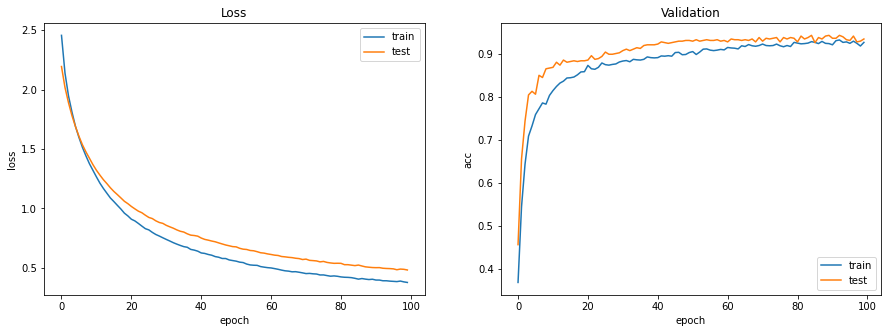

In [115]:
plot_loss_acc(model_history2_1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **EVALUACION CON ALEMAN**

Procesamos los datos de validación

In [210]:
data_validation = ProcessData()
datasetEMODB_dataset = shuffle(datasetEMODB)
X_val, X_test_val, Y_val, Y_test_val = data_validation.dataset_splitted(datasetEMODB_dataset, 0.1)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_val.shape, Y_val.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test_val.shape, Y_test_val.shape))

Dimensiones del conjunto de entrenamiento. Datos: (621, 40, 1) y clases: (621, 5)
Dimensiones del conjunto de test. Datos: (69, 40, 1) y clases: (69, 5)


In [211]:
from sklearn.metrics import classification_report

predicted_y = modelB.predict(X_val)
predicted_y = np.argmax(np.round(predicted_y), axis=1)

y_true = np.argmax(Y_val, axis=1)

# Mapeo con el nombre de las clases
X, Y = data_validation.get_categorical_classes(False, True)
mapping = dict(zip(y_true, Y))

predicted_y = list(map(mapping.get, predicted_y))
y_true = list(map(mapping.get, y_true))

In [212]:
print(classification_report(y_true, predicted_y ))

              precision    recall  f1-score   support

       angry       0.18      0.53      0.27       124
     disgust       0.23      0.20      0.22       125
       happy       0.60      0.45      0.51       124
     neutral       0.31      0.12      0.17       124
         sad       0.23      0.02      0.04       124

    accuracy                           0.27       621
   macro avg       0.31      0.27      0.24       621
weighted avg       0.31      0.27      0.24       621



#### **4.2.1 Data Augmentation**

In [216]:
augmented_savee_tess = datasetSAVEE_augmented.append(datasetTESS_augmented, ignore_index= True)
augmented_savee_tess = augmented_savee_tess.dropna()
augmented_savee_tess = shuffle(augmented_savee_tess)
print("La version aumentada de este dataset tiene {} instancias".format(len(augmented_savee_tess)))
augmented_savee_tess.head()

La version aumentada de este dataset tiene 4720 instancias


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
753,sad,-299.187337,15.153487,12.559813,8.849728,6.323772,3.134192,-2.395739,-4.958667,-4.889857,-3.971155,-4.065112,-3.487119,-3.531036,-2.556602,-2.042606,-1.913660,-0.594743,-1.346568,-1.380763,-1.416454,-0.962833,-1.757718,-2.197189,-1.440865,-1.441122,0.247858,1.600106,2.050806,3.352183,3.083465,1.758883,1.368847,0.892977,0.347576,1.813137,2.757681,3.903129,4.511644,4.821548,4.271061
1902,disgust,-254.086582,26.924485,-1.261986,3.727236,-4.586822,-1.353001,-4.952505,-8.846091,-6.021211,-0.729188,-5.172279,-5.503801,-4.386088,0.909497,-4.394824,-3.563740,-1.664227,-1.969973,-1.237825,-1.259240,-2.701757,-1.806477,-1.564433,-1.861827,-2.852352,-1.715913,-0.237995,-1.998419,-0.335242,0.676113,0.234259,0.301426,-1.201238,-2.223392,0.783193,1.564130,3.126518,3.609787,3.311780,4.282425
4350,disgust,-455.742798,86.338509,11.563093,7.967887,4.676503,11.751726,-18.530741,8.897447,-22.486078,0.983860,-10.174376,6.118921,-5.393463,2.253653,-3.079769,-0.211380,-5.812911,4.373427,-1.213993,-1.506299,2.097435,-3.583875,-1.592897,-0.495951,0.278594,5.833799,0.328845,4.081230,1.094930,4.853113,4.582049,3.303454,2.342594,2.007040,2.138508,4.472968,3.181472,5.409222,9.948736,9.959126
2485,disgust,-275.853270,32.661419,16.059203,6.270795,-0.364384,-4.201418,-7.061556,-4.365420,-5.474218,-4.132843,-3.606962,-0.917656,-0.488876,-0.357306,-0.366325,-1.331464,-1.028199,-1.667876,-2.191684,-2.447299,-2.052540,-2.317918,-2.155175,-1.908756,-0.991920,-1.331368,0.038937,1.087785,0.079904,1.235090,0.899148,-0.002545,1.239055,2.125946,3.313403,3.215965,2.665380,3.685615,3.827907,3.548041
482,happy,-347.109253,86.740524,6.508771,22.190424,15.010102,-0.541927,-17.464493,4.609902,-0.187708,-10.953825,-0.551896,1.174969,-2.085951,-1.328734,5.638387,-5.013860,-0.449704,5.262606,-4.103426,-1.045977,0.401671,-3.918338,-3.618959,-0.991585,-0.783312,1.157119,7.945414,13.071495,10.852225,11.111406,9.008214,3.125343,3.867076,3.179652,3.344232,4.600622,2.560641,2.246716,1.520822,0.715843


In [217]:
print(augmented_savee_tess['emotion'].value_counts())

neutral    1040
disgust     920
angry       920
happy       920
sad         920
Name: emotion, dtype: int64


In [218]:
X_train, X_test, Y_train, Y_test = processed_savee_tess.dataset_splitted(augmented_savee_tess)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (3540, 40, 1) y clases: (3540, 5)
Dimensiones del conjunto de test. Datos: (1180, 40, 1) y clases: (1180, 5)


In [219]:
data_validation = ProcessData()
X_val, X_test_val, Y_val, Y_test_val = data_validation.dataset_splitted(datasetEMODB, 0.1)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_val.shape, Y_val.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test_val.shape, Y_test_val.shape))

Dimensiones del conjunto de entrenamiento. Datos: (621, 40, 1) y clases: (621, 5)
Dimensiones del conjunto de test. Datos: (69, 40, 1) y clases: (69, 5)


In [220]:
model_aug2 = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history1_au = model_aug2.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


111/111 [==============================] - 3s 13ms/step - loss: 2.5597 - accuracy: 0.3689 - val_loss: 2.1040 - val_accuracy: 0.7093
Epoch 2/100
111/111 [==============================] - 1s 9ms/step - loss: 2.0418 - accuracy: 0.6816 - val_loss: 1.8650 - val_accuracy: 0.7839
Epoch 3/100
111/111 [==============================] - 1s 9ms/step - loss: 1.8003 - accuracy: 0.7402 - val_loss: 1.6943 - val_accuracy: 0.8212
Epoch 4/100
111/111 [==============================] - 1s 10ms/step - loss: 1.6079 - accuracy: 0.7851 - val_loss: 1.5527 - val_accuracy: 0.8280
Epoch 5/100
111/111 [==============================] - 1s 9ms/step - loss: 1.4793 - accuracy: 0.7875 - val_loss: 1.4487 - val_accuracy: 0.8271
Epoch 6/100
111/111 [==============================] - 1s 9ms/step - loss: 1.3504 - accuracy: 0.8176 - val_loss: 1.3570 - val_accuracy: 0.8398
Epoch 7/100
111/111 [==============================] - 1s 9ms/step - loss: 1.2588 - accuracy: 0.8051 - val_loss: 1.2838 - val_accuracy: 0.8390
Epoch 8/1

74/74 [==============================] - 0s 2ms/step - loss: 0.4841 - accuracy: 0.8890
Loss: 0.48407432436943054 
Accuracy: 88.89830708503723%


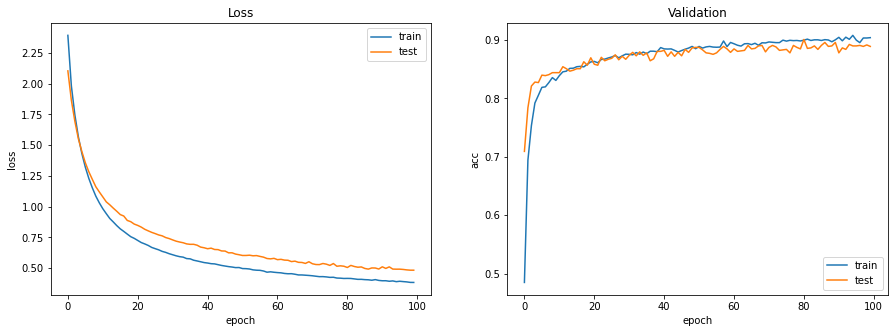

In [221]:
plot_loss_acc(model_history1_au)
# Evaluamos contra test
score = model_aug2.evaluate(X_test, Y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

In [228]:
from sklearn.metrics import classification_report

predicted_y = model_aug2.predict(X_val)
predicted_y = np.argmax(np.round(predicted_y), axis=1)

y_true = np.argmax(Y_val, axis=1)

# Mapeo con el nombre de las clases
X, Y = data_validation.get_categorical_classes(False, True)
mapping = dict(zip(y_true, Y))

predicted_y = list(map(mapping.get, predicted_y))
y_true = list(map(mapping.get, y_true))

In [229]:
print(classification_report(y_true, predicted_y ))

              precision    recall  f1-score   support

       angry       0.16      0.40      0.23       124
     disgust       0.25      0.16      0.20       125
       happy       0.57      0.55      0.56       124
     neutral       0.27      0.11      0.16       124
         sad       0.49      0.23      0.32       124

    accuracy                           0.29       621
   macro avg       0.35      0.29      0.29       621
weighted avg       0.35      0.29      0.29       621



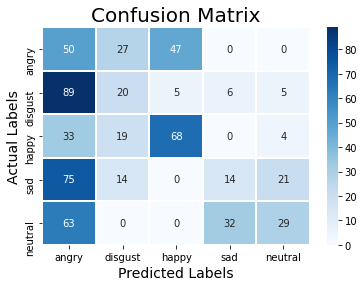

In [251]:
categories = mapping.values()
cm = confusion_matrix(y_true, predicted_y)
sns.heatmap(cm, linecolor='white', 
            cmap='Blues', 
            linewidth=1, 
            annot=True, 
            fmt='', 
            xticklabels=categories, 
            yticklabels=categories ) 

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
modelB.save(GPATH + 'SpeechEmotionRecognition/models/model_TESS_SAVEE_05cnn1.h5')
modelB.save(GPATH + 'SpeechEmotionRecognition/models/model_TESS_SAVEE_05cnn1_augmented.h5')